---
title: 12.3 Supervised Learning with Artificial Neural Networks Using Scikit-Learn

---

# Supervised Learning with Artificial Neural Networks Using Scikit-Learn

**Author:** Chao Lu  
**Project title:** INnovative Geothermal Exploration through Novel Investigations Of Undiscovered Systems (INGENIOUS)  
**Affiliation:** University of Nevada, Reno – Nevada Bureau of Mining and Geology (NBMG) and Great Basin Center for Geothermal Energy (GBCGE)  
**Last Modified:** July 3, 2024  
**Program partners:** Aprovechar Lab L3C (L3C) - Stephen Brown; University of Nevada, Reno (UNR) - James Faulds, Maria Richards, Elijah Mlawsky, Cary Lindsey, Nicole Hart-Wagoner

## Introduction  
In this chapter, we delve into the realm of supervised learning, specifically focusing on the application of artificial neural networks (ANNs) using the `Scikit-Learn` library. Scikit-Learn, a robust and user-friendly machine learning library in Python, provides a comprehensive set of tools for building and training ANNs. We will explore how to define neural network architectures, tune hyperparameters to optimize model performance, evaluate model performance, and use the model to make predictions. By the end of this chapter, you will have a solid understanding of how to leverage Scikit-Learn to implement and fine-tune artificial neural networks for a binary classification task.

## 1. Loading the dataset  
In this section, we will load the preprocessed dataset from an HDF5 file. The dataset has been preprocessed to handle missing values, scale features, and encode categorical variables. We will read the training, validation, test, and unlabeled datasets into memory and apply feature selection to ensure our model uses the most relevant features. This setup is crucial for training our artificial neural network effectively.

**Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, log_loss
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
import joblib
# Define random state (User option)
seed = 88

**Loading preprocessed data**  
In this step, we will read the preprocessed datasets from the HDF5 file `preprocessed_data.h5` into pandas DataFrames.

In [2]:
# Modify the line below to specify a different directory (user option)
data_path = r'C:\Users\chaolu\Project folder\INGENIOUS\Playbook\workplace\data'
# Specify the name of the data file to be read (user option)
data_filename1 = 'preprocessed_data.h5'
# Construct the full file path
file_path1 = os.path.join(data_path, data_filename1)
# Read the data from the HDF5 file
with pd.HDFStore(file_path1, 'r') as store:
    X_train_preprocessed = store['X_train_preprocessed']
    X_test_preprocessed = store['X_test_preprocessed']
    y_train = store['y_train']
    y_test = store['y_test']
    X_unlabeled_preprocessed = store['X_unlabeled_preprocessed']
    df_info = store ['df_info']

**Splitting data**  
In this step, we will split the training data into separate training and validation sets named `X_train`, `X_val`, `y_train`, and `y_val`. This allows us to effectively evaluate the model's performance during the training process, ensuring that it generalizes well to unseen data.

In [3]:
# Split the training data into training and validation sets (user option)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_preprocessed, y_train, test_size=0.2, random_state=seed, stratify=y_train
)

**Feature selection**  
In this step, we select a subset of `features` to be used for training, validation, testing, and the unlabeled dataset. Feature selection ensures that our model focuses on the most relevant and informative features, enhancing both its performance and efficiency.

In [4]:
# Define the features used for your ML model (user option)
features = ['QuaternaryFaultTraces', 'HorizGravityGradient2', 'HorizMagneticGradient2',
            'GeodeticStrainRate', 'QuaternarySlipRate', 'FaultRecency',
            'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow', 'DEM-30m']
# Apply feature selection to training, validation, test, and unlabeled datasets
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test_preprocessed[features]
X_unlabeled = X_unlabeled_preprocessed[features]

**Validation**  
In this step, we print the shapes of the datasets to confirm that the data has been loaded and processed correctly. This ensures that each dataset is correctly prepared for subsequent modeling and analysis.

In [5]:
# Print the shapes of the datasets to confirm successful feature selection
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("X_unlabeled shape:", X_unlabeled.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (86, 10)
X_val shape: (22, 10)
X_test shape: (37, 10)
X_unlabeled shape: (1697327, 10)
y_train shape: (86,)
y_val shape: (22,)
y_test shape: (37,)


## 2. Initialize and define the baseline ANN model for performance evaluation

**Initialize the ANN architecture**  
In this section, we initialize and define the architecture for an Artificial Neural Network (ANN) using the `MLPClassifier` from the `scikit-learn` library. The ANN is set up with two hidden layers, each containing 16 neurons. The ReLU (Rectified Linear Unit) activation function is used for these neurons to introduce non-linearity into the model. The Adam optimizer is chosen for efficient optimization during training. The max_iter parameter is set to 1, allowing manual control over the number of training iterations (epochs). The warm_start parameter is enabled to reuse the model state from previous iterations, facilitating incremental learning. A random seed is specified to ensure the reproducibility of the results. This architecture is also the structure used in a previous Nevada geothermal machine learning project.

In [6]:
# Initialize and define the ANN architecture
mlp = MLPClassifier(hidden_layer_sizes=(16,16),  # Two hidden layers with 16 neurons each
                    activation='relu',          # Use ReLU as the activation function
                    solver='adam',              # Use Adam optimizer
                    max_iter=1,                 # We will manually handle iterations
                    warm_start=True,            # Allow reuse of previous model state
                    random_state=seed)          # Seed for reproducibility
# Initialize lists to store loss and F1 score for each epoch
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

Our fully connected neural network architecture is plotted using [**NN-SVG**](http://alexlenail.me/NN-SVG/).

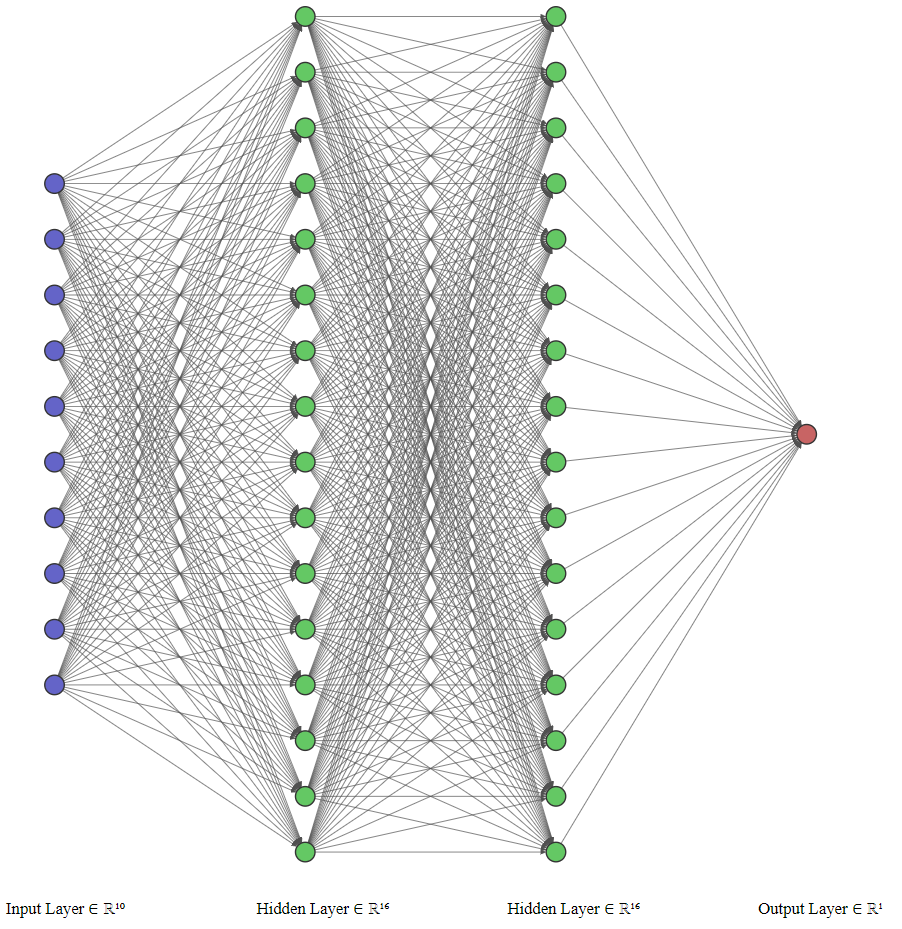

**Training loop**  
In this section, we train the ANN over 300 epochs. For each epoch, we make predictions for the training data and calculate the probabilities using `predict_proba`. We compute and store the `log_loss` and `f1_score` for the training data. Similarly, we compute and store predictions and performance metrics for the validation data. Progress is printed after each epoch, displaying the current epoch number, training loss, validation loss, training F1 score, and validation F1 score. This setup helps in monitoring the model's performance over time.

In [7]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Training loop
epochs = 300
for epoch in range(epochs):
    mlp.fit(X_train, y_train)
    
    # Get training predictions and calculate training loss and F1 score
    y_train_pred_prob = mlp.predict_proba(X_train)
    y_train_pred = mlp.predict(X_train)
    train_loss = log_loss(y_train, y_train_pred_prob)
    train_f1 = f1_score(y_train, y_train_pred)
    
    # Get validation predictions and calculate validation loss and F1 score
    y_val_pred_prob = mlp.predict_proba(X_val)
    y_val_pred = mlp.predict(X_val)
    val_loss = log_loss(y_val, y_val_pred_prob)
    val_f1 = f1_score(y_val, y_val_pred)
    
    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, '
          f'Train F1 score: {train_f1:.4f}, Validation F1 score: {val_f1:.4f}')

Epoch 1/300 - Train loss: 0.7282, Validation loss: 0.7531, Train F1 score: 0.0400, Validation F1 score: 0.0000
Epoch 2/300 - Train loss: 0.7232, Validation loss: 0.7498, Train F1 score: 0.0400, Validation F1 score: 0.0000
Epoch 3/300 - Train loss: 0.7184, Validation loss: 0.7466, Train F1 score: 0.0400, Validation F1 score: 0.0000
Epoch 4/300 - Train loss: 0.7137, Validation loss: 0.7434, Train F1 score: 0.0400, Validation F1 score: 0.0000
Epoch 5/300 - Train loss: 0.7092, Validation loss: 0.7407, Train F1 score: 0.1154, Validation F1 score: 0.0000
Epoch 6/300 - Train loss: 0.7048, Validation loss: 0.7377, Train F1 score: 0.1154, Validation F1 score: 0.0000
Epoch 7/300 - Train loss: 0.7005, Validation loss: 0.7350, Train F1 score: 0.1509, Validation F1 score: 0.0000
Epoch 8/300 - Train loss: 0.6964, Validation loss: 0.7321, Train F1 score: 0.1509, Validation F1 score: 0.1429
Epoch 9/300 - Train loss: 0.6924, Validation loss: 0.7296, Train F1 score: 0.1509, Validation F1 score: 0.1429
E

**Plotting loss and F1 score over time**  
In this section, we create a figure with two subplots to visualize the training process of the MLP Classifier. The first subplot shows the training and validation loss over the epochs, while the second subplot displays the training and validation F1 scores. Each subplot includes labels for the axes, a title, and a legend to distinguish between training and validation metrics. The overall title, "MLP Classifier Training Performance," is set for the figure, and the layout is adjusted to ensure proper spacing. This visualization helps in understanding how the model's performance evolves over time.

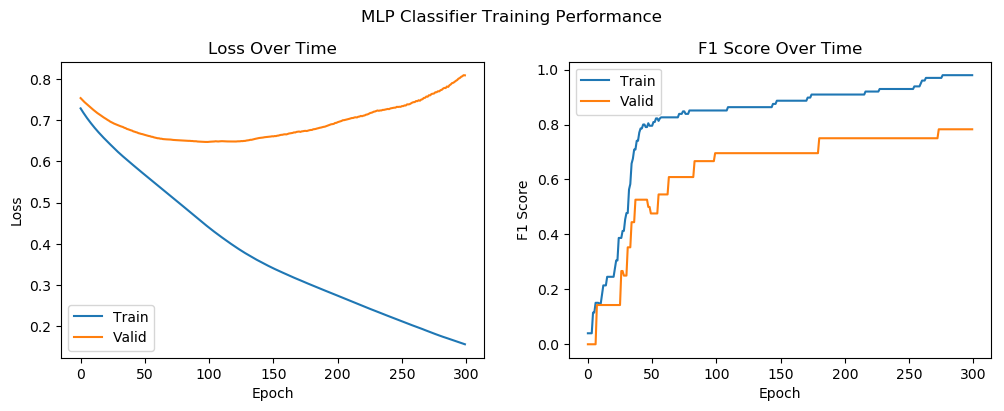

In [8]:
# Plotting loss and F1 score over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Valid')
ax1.set_title('Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_f1_scores, label='Train')
ax2.plot(val_f1_scores, label='Valid')
ax2.set_title('F1 Score Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.legend()

plt.suptitle('MLP Classifier Training Performance')
plt.subplots_adjust(top=0.85)
plt.show()

**Conclusion for the initial model**  
* Overfitting: The increase in validation loss and the plateauing of validation F1 score indicate overfitting. The model performs well on the training data but struggles to generalize to the validation data.
* Model Performance: Despite overfitting, the initial model achieves a reasonable F1 score on the validation data, suggesting that it has learned some useful patterns in the data.

**Next steps**
* Regularization: Implementing techniques such as dropout or L2 regularization can help mitigate overfitting.
* Early Stopping: Introducing early stopping based on validation loss can prevent the model from training too long and overfitting.
* Hyperparameter Tuning: Experimenting with different hyperparameters (e.g., learning rate, number of neurons, number of layers) can further improve model performance and generalization.  
This initial model serves as a baseline for further experimentation and optimization to enhance performance and reduce overfitting.

## 3. Hyperparameter tuning with GridSearchCV
In this section, we perform hyperparameter tuning to optimize the performance of our ANN using `GridSearchCV` from the `scikit-learn` library. 

**Define the parameter grid**  
We define a `param_grid` that includes various configurations for the network's architecture and learning parameters. The grid includes different sizes for hidden layers (e.g., (8, 8), (16, 16), (32, 32), (16, 16, 16)), regularization strength values (`alpha`), initial learning rates (`learning_rate_init`), activation functions (`relu`, `tanh`, `logistic`), and optimization solvers (`adam`, `sgd`).

In [9]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(8, 8), (16, 16), (32, 32), (16, 16, 16)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd']
}

**Early stopping**  
The MLPClassifier is initialized with `early_stopping` enabled to prevent overfitting. The maximum number of iterations (`max_iter`) is set to 200, as we learned from the initial model that 300 iterations were excessive. We then combine the training and validation datasets into `X_train_full` and `y_train_full` to perform cross-validation, ensuring a robust evaluation of each hyperparameter combination.

In [10]:
# Initialize the MLPClassifier with early stopping
mlp = MLPClassifier(max_iter=200, early_stopping=True, random_state=seed)
# Combine the train and validation data for cross-validation
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat((y_train, y_val), axis=0)

**GridSearchCV**  
Using `GridSearchCV`, we perform a 5-fold cross-validation to find the best hyperparameters for our model, optimizing for the F1 score. The total duration of the grid search is measured. The best hyperparameters (`best_params`) and the total time taken are printed, ensuring we find the optimal configuration for our ANN.

In [11]:
# Perform hyperparameter tuning using GridSearchCV with cross-validation
start_time = time.time()
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_full, y_train_full)
end_time = time.time()
# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")
print(f"Total time taken for grid search: {end_time - start_time:.4f} seconds")

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8, 8), 'learning_rate_init': 0.1, 'solver': 'adam'}
Total time taken for grid search: 2.7829 seconds


## 4. Train and evaluate the final model  
In this section, we train the final model using the best hyperparameters found during the grid search. We then evaluate its performance on the test set and analyze the results.

**Initialize the ANN architecture with optimal hyperparameters**  
In this step, we construct the ANN architecture using the `best_params` identified during the hyperparameter tuning process with GridSearchCV. These hyperparameters have been carefully selected to enhance the performance of our model. By leveraging the best combination of hidden layer sizes, regularization strength, learning rate, activation function, and solver, we aim to achieve a well-optimized neural network. This configuration ensures that the model is set up for efficient learning and improved generalization.

In [12]:
# Initialize the MLPClassifier with the best hyperparameters and no early stopping
best_mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                         alpha=best_params['alpha'],
                         learning_rate_init=best_params['learning_rate_init'],
                         activation=best_params['activation'],
                         solver=best_params['solver'],
                         max_iter=1,  # We'll handle the iterations manually
                         warm_start=True,  # Allow reuse of previous model state
                         random_state=seed)

Our optimal neural network architecture is visualized using [**NN-SVG**](http://alexlenail.me/NN-SVG/).

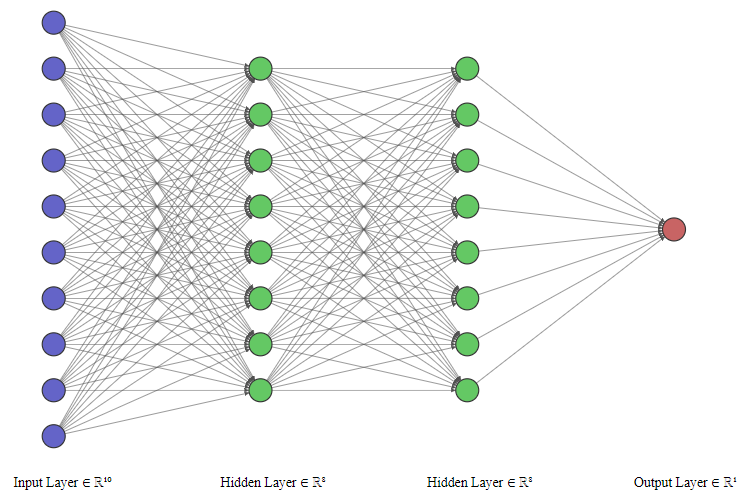

**Training and Evaluation Loop**  
In this section, we train the ANN using the best hyperparameters identified during the tuning process. We also evaluate its performance on the training and test datasets over multiple epochs. The number of epochs is reduced to 99 based on our observations during the initial testing phase.

In [13]:
# Initialize lists to store loss and F1 score for each epoch
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Training loop
epochs = 99
for epoch in range(epochs):
    best_mlp.fit(X_train_full, y_train_full)
    # Get training predictions and calculate training loss and F1 score
    y_train_pred_prob = best_mlp.predict_proba(X_train_full)
    y_train_pred = best_mlp.predict(X_train_full)
    train_loss = log_loss(y_train_full, y_train_pred_prob)
    train_f1 = f1_score(y_train_full, y_train_pred)
    # Get validation predictions and calculate validation loss and F1 score
    y_test_pred_prob = best_mlp.predict_proba(X_test)
    y_test_pred = best_mlp.predict(X_test)
    test_loss = log_loss(y_test, y_test_pred_prob)
    test_f1 = f1_score(y_test, y_test_pred)  
    # Append metrics to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1) 
    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, '
          f'Train F1 score: {train_f1:.4f}, Test F1 score: {test_f1:.4f}')

Epoch 1/99 - Train loss: 0.6614, Test loss: 0.7739, Train F1 score: 0.6993, Test F1 score: 0.6400
Epoch 2/99 - Train loss: 0.5893, Test loss: 0.5073, Train F1 score: 0.7255, Test F1 score: 0.8205
Epoch 3/99 - Train loss: 0.5938, Test loss: 0.6845, Train F1 score: 0.7518, Test F1 score: 0.7059
Epoch 4/99 - Train loss: 0.5501, Test loss: 0.5285, Train F1 score: 0.7500, Test F1 score: 0.8205
Epoch 5/99 - Train loss: 0.5471, Test loss: 0.6954, Train F1 score: 0.7914, Test F1 score: 0.6923
Epoch 6/99 - Train loss: 0.5540, Test loss: 0.6307, Train F1 score: 0.7573, Test F1 score: 0.6667
Epoch 7/99 - Train loss: 0.5147, Test loss: 0.6298, Train F1 score: 0.7660, Test F1 score: 0.7170
Epoch 8/99 - Train loss: 0.5489, Test loss: 0.6041, Train F1 score: 0.7327, Test F1 score: 0.6667
Epoch 9/99 - Train loss: 0.4923, Test loss: 0.6280, Train F1 score: 0.7883, Test F1 score: 0.7600
Epoch 10/99 - Train loss: 0.5085, Test loss: 0.6619, Train F1 score: 0.7573, Test F1 score: 0.6471
Epoch 11/99 - Train

**Plotting Loss and F1 Score Over Time**  
In this section, we visualize the performance of the ANN by plotting the loss and F1 scores for both the training and test datasets over the course of 100 epochs. These plots help us understand how well the model is learning and generalizing to new data. The training F1 score increases gradually and stabilizes around a higher value. This trend reflects that the model's ability to correctly classify the training data improves and reaches a point of stability. The test F1 score exhibits substantial variability and does not demonstrate a consistent improvement. The fluctuations in the test F1 score suggest that the model's performance on unseen data is unstable, which may also point to overfitting or noise in the data.

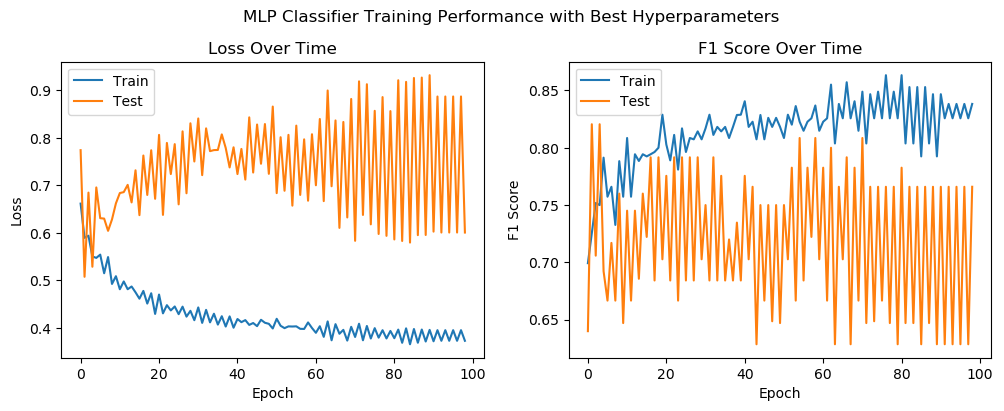

In [14]:
# Plotting loss and F1 score over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_title('Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_f1_scores, label='Train')
ax2.plot(test_f1_scores, label='Test')
ax2.set_title('F1 Score Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.legend()

plt.suptitle('MLP Classifier Training Performance with Best Hyperparameters')
plt.subplots_adjust(top=0.85)
plt.show()

## 5. Additional evaluations

**Evaluate on additional metrics**  
The model exhibits a reasonable balance between `precision_score` (0.6923) and `recall_score` (0.8571). This indicates that while the model is relatively good at identifying positive cases (high recall). The The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) as `roc_auc_score` of 0.8482 demonstrates that the model performs well in distinguishing between the positive and negative classes, which is a strong indicator of its overall effectiveness.

In [15]:
# Evaluate additional metrics on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob[:, 1])

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.7027
Test Precision: 0.6923
Test Recall: 0.8571
Test ROC AUC: 0.8482


**Confusion matrix**  
The `confusion_matrix` provides a detailed breakdown of the model's performance in terms of true positives, true negatives, false positives, and false negatives.
* True Positives (TP): 18. The model correctly predicted the positive class for 18 instances.
* True Negatives (TN): 8. The model correctly predicted the negative class for 8 instances.
* False Positives (FP): 8. The model incorrectly predicted the positive class for 8 instances (Type I error).
* False Negatives (FN): 3. The model incorrectly predicted the negative class for 3 instances (Type II error).

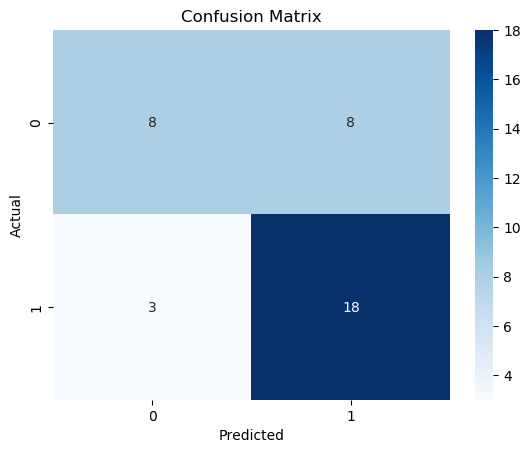

In [16]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC curve and AUC**  
The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) provide valuable insights into the model's performance in distinguishing between positive and negative classes. The AUC value `roc_auc` of 0.85 suggests that the model has a strong ability to discriminate between the two classes. An AUC of 0.85 indicates that there is an 85% chance that the model will correctly distinguish between a randomly chosen positive instance and a randomly chosen negative instance.

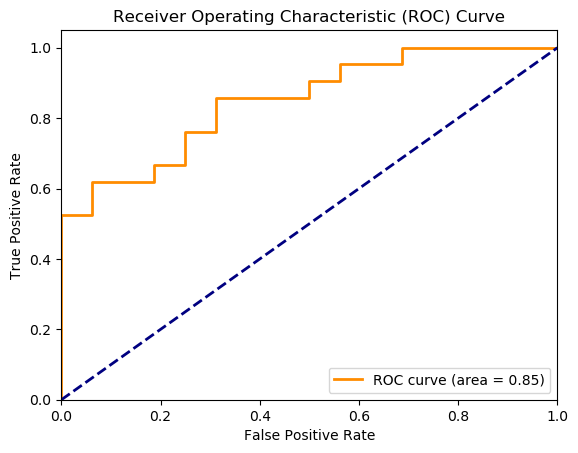

In [17]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Learning curves**  
The learning curves provide insights into how the model's performance evolves with varying sizes of the training set.
* Training Score (Blue line): The training score initially increases as the number of training examples increases, peaking at around 50 examples. After reaching the peak, the training score decreases slightly as more training examples are added. This behavior suggests that the model is initially overfitting the small dataset but starts to generalize better as more data are added.
* Cross-Validation Score (Red line): The cross-validation score increases as the number of training examples increases, indicating that the model's generalization performance improves with more data. The cross-validation score reaches a peak and then decreases slightly, suggesting that the model might start to underfit or is not gaining significant additional benefit from more data.

The learning curves suggest that the model initially overfits with smaller datasets but improves its generalization as more data are added. However, there is still room for improvement in reducing the gap between the training and cross-validation scores. Collecting more training data, if possible, would be beneficial, as the learning curves indicate that the model benefits from additional data.

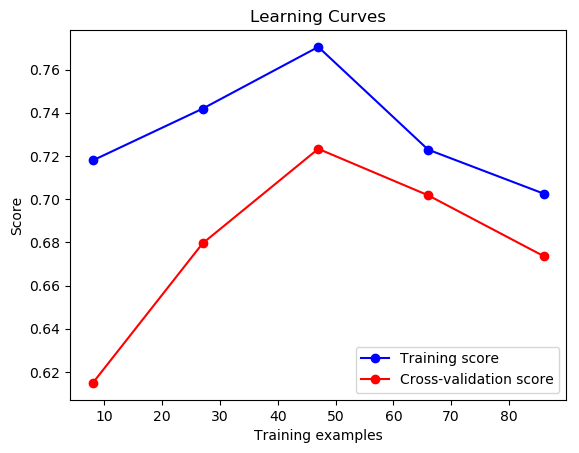

In [18]:
# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train_full, y_train_full, cv=5, scoring='f1')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

**Cross-Validation**  
Cross-validation helps to ensure that the model's performance is consistent across different subsets of the data. Here, we perform 5-fold cross-validation to evaluate the F1 score of our model. The cross-validation results show a consistent performance across different subsets of the data, with a mean F1 score of 0.6736. While the model demonstrates stability, there is still room for improvement.

In [19]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(best_mlp, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {np.mean(cv_scores):.4f}")

Cross-Validation F1 Scores: [0.66666667 0.70967742 0.70967742 0.61538462 0.66666667]
Mean Cross-Validation F1 Score: 0.6736


## 6. Saving and loading the model

**Save the trained model**  
We will now save the trained final model so that we can reload it at any time without having to retrain it from scratch. The model is saved as `ANN_sklearn_best.pkl` in our designated model directory.

In [20]:
# Save the trained model to a file
model_filename = 'ANN_sklearn_best.pkl'
model_path = r'C:\Users\chaolu\Project folder\INGENIOUS\Playbook\workplace\models\ANN with sklearn'
full_model_path = f'{model_path}\\{model_filename}'
joblib.dump(best_mlp, full_model_path)
# Print confirmation with the correct directory and file name
print(f"Model saved to {full_model_path}")

Model saved to C:\Users\chaolu\Project folder\INGENIOUS\Playbook\workplace\models\ANN with sklearn\ANN_sklearn_best.pkl


**Loading the model**  
We will now load the previously saved model so that we can use it for making predictions or further evaluations. The model file `ANN_sklearn_best.pkl` will be loaded from our designated model directory into `ANN_sklearn_best_model`.

In [21]:
# Load the saved model
ANN_sklearn_best_model = joblib.load(full_model_path)
# Print confirmation
print(f"Model loaded from {full_model_path}")

Model loaded from C:\Users\chaolu\Project folder\INGENIOUS\Playbook\workplace\models\ANN with sklearn\ANN_sklearn_best.pkl


## 7. Making predictions  
In this step, we use the best-trained ANN model to make probability predictions on the unlabeled dataset.

**Make probability predictions**  
The model, loaded from the saved state, predicts the probability of each class (`prob_class_0` and `prob_class_1`) for the unlabeled data points. We then convert these predictions into a DataFrame, maintaining the same index as the input data for consistency. This allows us to seamlessly integrate the predictions with the original dataset for further analysis. By examining the size and initial entries of the predictions DataFrame, we can verify the successful execution of the prediction process.

In [22]:
# Make probability predictions with the loaded model
ANN_sklearn_best_predictions = ANN_sklearn_best_model.predict_proba(X_unlabeled)
# Convert predictions to DataFrame with the same index as the input data
ANN_sklearn_best_predictions_df = pd.DataFrame(ANN_sklearn_best_predictions, index=X_unlabeled.index, columns=['prob_class_0', 'prob_class_1'])
# Print the size of the predictions
print(f"Total number of predictions: {len(ANN_sklearn_best_predictions_df)}")
# Print the first 5 predictions
print("First 5 predictions:")
print(ANN_sklearn_best_predictions_df.head())

Total number of predictions: 1697327
First 5 predictions:
   prob_class_0  prob_class_1
0      0.016375      0.983625
1      0.014946      0.985054
2      0.020001      0.979999
3      0.012446      0.987554
4      0.007786      0.992214


**Plot histograms of predicted probabilities**  
The histograms displayed below show the distribution of predicted probabilities for the negative and positive classes across the study area. The model demonstrates high confidence in its predictions for both classes, with many predictions at the extremes (0 for negative and 1 for positive). It is essential to validate the model on diverse and unseen datasets to ensure that it generalizes well and does not just perform well on the training data.

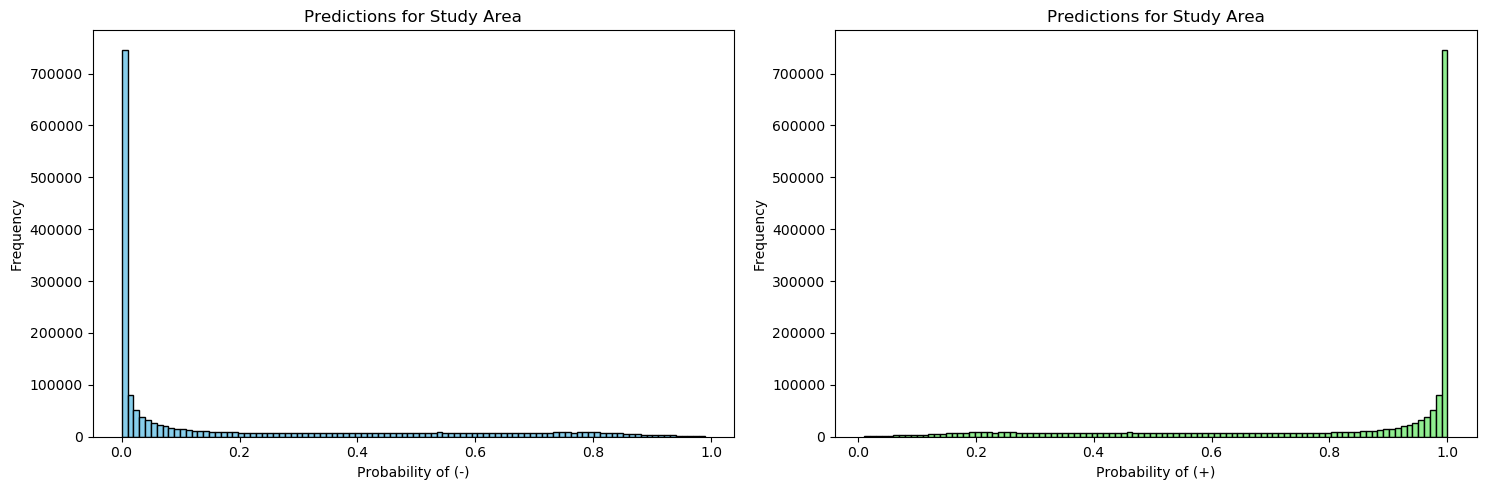

In [23]:
# Plot histograms
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Histogram for the probability of the negative class
ax[0].hist(ANN_sklearn_best_predictions_df['prob_class_0'], bins=100, color='skyblue', edgecolor='black')
ax[0].set_title('Predictions for Study Area')
ax[0].set_xlabel('Probability of (-)')
ax[0].set_ylabel('Frequency')
# Histogram for the probability of the positive class
ax[1].hist(ANN_sklearn_best_predictions_df['prob_class_1'], bins=100, color='lightgreen', edgecolor='black')
ax[1].set_title('Predictions for Study Area')
ax[1].set_xlabel('Probability of (+)')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

**Merging predictions with geographical information and visualizing on a map**  
In this section, we merge the probability predictions with the geographical information to visualize the results on a map. This process involves joining the predictions with the coordinates, reshaping the data, and plotting it along with the labeled points.

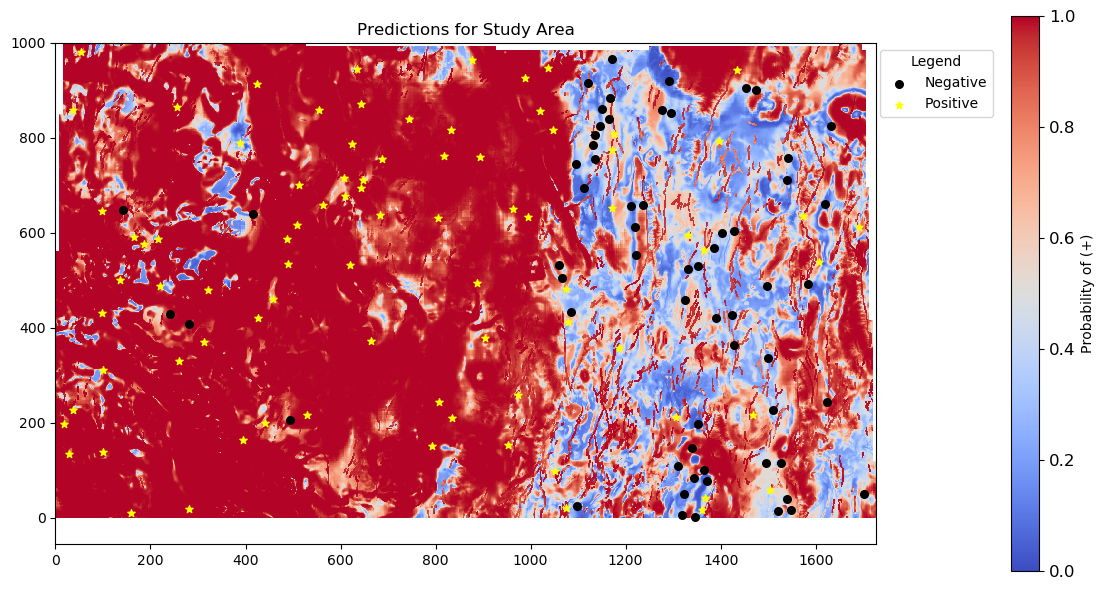

In [24]:
# Merge the predictions with the geographical information, keeping all entries from df_info
predictions_with_geo = df_info[['latitude', 'longitude']].join(ANN_sklearn_best_predictions_df['prob_class_1'], how='left')
# Reshape the predictions to the desired shape
predictions_reshaped = predictions_with_geo['prob_class_1'].values.reshape((1000, 1728))

# Combine y_train_full and y_test into a single Series
labels = pd.concat([y_train_full, y_test])
# Merge labels with df_info
labels_with_geo = df_info[['latitude', 'longitude']].join(labels.rename('label'), how='left')
# Reshape the labels to the desired shape
labels_reshaped = labels_with_geo['label'].values.reshape((1000, 1728))
# Find positions where label is 1 (positive)
pos_rows, pos_cols = np.where(labels_reshaped == 1)
# Find positions where label is 0 (negative)
neg_rows, neg_cols = np.where(labels_reshaped == 0)

# Plotting the reshaped predictions on a map with labeled points
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(predictions_reshaped, origin='lower', cmap='coolwarm', vmin=0.0, vmax=1.0)
cbar = plt.colorbar(im, label='Probability of (+)', ax=ax, pad=0.12)
cbar.ax.tick_params(labelsize=12)
# Add title and labels with specified font sizes
plt.title('Predictions for Study Area', fontsize=12)
# Overlay the labeled points
ax.scatter(neg_cols, neg_rows, color='black', label='Negative', marker='o', s=30)
ax.scatter(pos_cols, pos_rows, color='yellow', label='Positive', marker='*', s=30)
legend = ax.legend(loc='best', bbox_to_anchor=(1.15, 1), title="Legend")
# Adjust the layout to minimize empty space
plt.tight_layout()
plt.show()

## Summary and future improvements

**Current observations:**  
1. **Mean F1-score:** The mean F1-score of 0.6736 is not satisfactory, indicating the model's performance needs improvement.
2. **Dropout limitation:** Scikit-learn does not support dropout rate configuration, which is a limitation for regularization.
3. **Hyperparameter tuning:** Only GridSearchCV was used for hyperparameter tuning.
4. **Prediction skewness:** Predictions are highly skewed towards 0 or 1, suggesting the model is very confident about its predictions but may lack nuance.
5. **Geographical distribution:** Based on the map, most of the negative labels are concentrated on the east side, which leads to a concentration of positive predictions in the center-west area.

**Future improvements:**
1. **Exploring alternative libraries:** Try using Keras and PyTorch to build the model, which allows for more advanced configurations such as dropout rates and more complex architectures.
2. **Hyperparameter tuning techniques:** Implement RandomSearchCV or other optimization techniques for hyperparameter tuning to explore a wider range of parameters more efficiently.
3. **Data augmentation:** If possible, acquire more labeled data, specifically balanced negative and positive samples, to ensure the model does not become biased towards geographically concentrated labels.
4. **Regularization and optimization:** Use advanced regularization techniques available in Keras and PyTorch to prevent overfitting and improve model generalization.
5. **Model architecture:** Experiment with different network architectures and configurations to find an optimal balance between complexity and performance.
6. **Cross-validation:** Implement more robust cross-validation strategies to ensure the model's performance is consistent and reliable across different subsets of the data.